### Imports

In [80]:
import os
import cv2
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List
from collections import namedtuple
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

### Labels

In [81]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# function to get the label from the name
def find_label(name):
    for label in labels:
        if label.name == name:
            return label.trainId, label.color
    return 255, (0,0,0)

### Loading Data

In [82]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
# train_images_folder = '/kaggle/input/cityscapes-segmentation/images/train'
# train_labels_folder = '/kaggle/input/cityscapes-segmentation/labels/train'

# training_csv_file_path = '/kaggle/working/cityscapes_training.csv'
# val_csv_file_path = '/kaggle/working/cityscapes_val.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# current_dir = os.path.dirname(os.getcwd())
train_images_folder = '/kaggle/input/images/train'
train_labels_folder = '/kaggle/input/labels/train'

# training_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_training.csv')
# val_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_val.csv')
#--------------------------------------------------------------------------------

data = {
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}
for city in os.listdir(train_images_folder):
    city_image_folder = os.path.join(train_images_folder, city)
    city_label_folder = os.path.join(train_labels_folder, city)
    # print(f"Processing {city} ...")
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            # print(f"Processing {image_file} ...")
            if image_file.endswith('_leftImg8bit.png'):
                image_name_base = image_file.replace('_leftImg8bit.png', '')
                label_mask_file = f"{image_name_base}_gtFine_labelTrainIds.png"
                label_json_file = f"{image_name_base}_gtFine_polygons.json"
                
                data['image_path'].append(os.path.join(city_image_folder, image_file))
                data['label_mask_path'].append(os.path.join(city_label_folder, label_mask_file))
                data['label_json_path'].append(os.path.join(city_label_folder, label_json_file))
 
df = pd.DataFrame(data)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=23, shuffle=True)
# train_df.to_csv(training_csv_file_path, index=False)
# val_df.to_csv(val_csv_file_path, index=False)

In [83]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
test_images_folder = '/kaggle/input/images/test'

# test_csv_file_path = '/kaggle/working/cityscapes_test.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# test_images_folder = os.path.join(current_dir, 'DataSet\\Images\\Test_Set')

# test_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_test.csv')
#--------------------------------------------------------------------------------

test_data = {
    'image_path': []
}

for city in os.listdir(test_images_folder):
    city_image_folder = os.path.join(test_images_folder, city)
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            if image_file.endswith('_leftImg8bit.png'):
                test_data['image_path'].append(os.path.join(city_image_folder, image_file))

test_df = pd.DataFrame(test_data)

# test_df.to_csv(test_csv_file_path, index=False)

### EDA

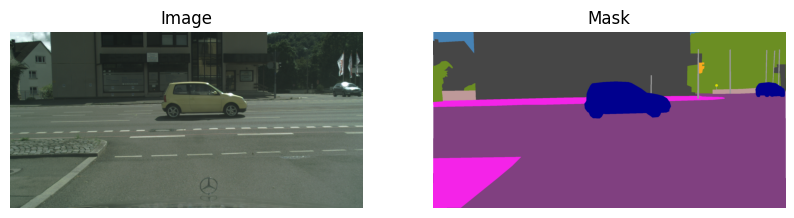

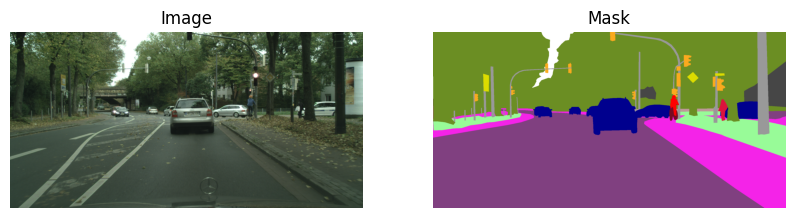

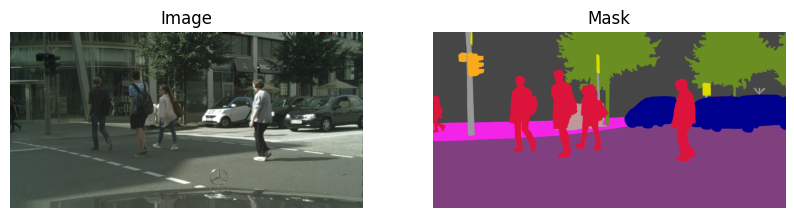

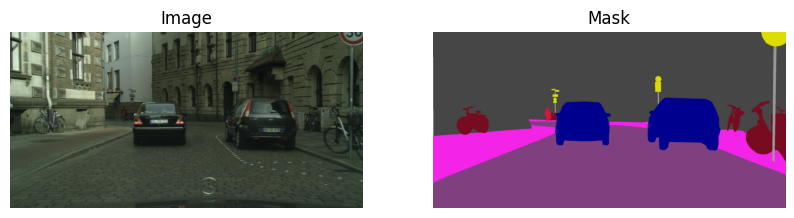

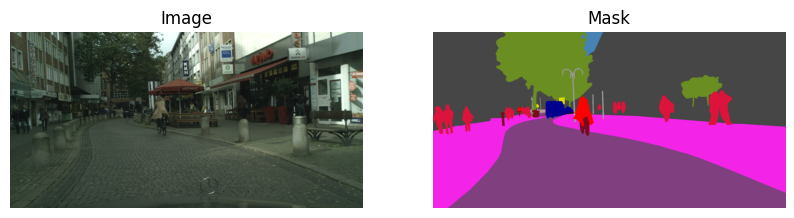

In [84]:
# Displaying A Sample of Images and Masks
def show_img_mask(row):
    image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(row['label_mask_path'])

    json_data = json.load(open(row['label_json_path']))

    for obj in json_data['objects']:
        label = obj['label']
        trainId, color = find_label(label)
        if trainId != 255:
            mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Mask')
    plt.show()

rSample = train_df.sample(5)
for index, row in rSample.iterrows():
    show_img_mask(row)

In [85]:
# # Analyzing the Distribution of the Labels accross the train Dataset
# labels_freq = {label.name: 0 for label in labels}
# labels_not_found = {}

# dimensions_freq = {}

# for index, row in train_df.iterrows():
#     json_data = json.load(open(row['label_json_path']))
    
#     dimensions = f"{json_data['imgWidth']}x{json_data['imgHeight']}"
#     dimensions_freq[dimensions] = dimensions_freq.get(dimensions, 0) + 1

#     for obj in json_data['objects']:
#         label = obj['label']
#         if label in labels_freq:
#             labels_freq[label] += 1
#         else:
#             if label not in labels_not_found:
#                 labels_not_found[label] = 1
#             else:
#                 labels_not_found[label] += 1
        
# plt.figure(figsize=(20, 10))
# plt.bar(labels_freq.keys(), labels_freq.values())
# plt.xticks(rotation=90)
# plt.show()
# print(labels_not_found)

In [86]:
# # Pixels Covered by Each Label
# def get_labels_pixels(row):
#     mask = cv2.imread(row['label_mask_path'])
#     json_data = json.load(open(row['label_json_path']))

#     for obj in json_data['objects']:
#         label = obj['label']
#         trainId, color = find_label(label)
#         if trainId != 255:
#             mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

#     return mask

# train_df['label_mask'] = train_df.apply(get_labels_pixels, axis=1)

# labels_pixels = {label.name: 0 for label in labels if label.trainId != 255}
# labels_pixels['Others'] = 0

# for index, row in train_df.iterrows():
#     for label in labels:
#         if label.trainId != 255:
#             labels_pixels[label.name] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
#                                                 (row['label_mask'][:,:,1] == label.color[1]) &
#                                                 (row['label_mask'][:,:,2] == label.color[2]))
#         else:
#             labels_pixels['Others'] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
#                                               (row['label_mask'][:,:,1] == label.color[1]) &
#                                               (row['label_mask'][:,:,2] == label.color[2]))

# plt.figure(figsize=(20, 10))
# plt.bar(labels_pixels.keys(), labels_pixels.values())
# plt.xticks(rotation=90)
# plt.show()

In [87]:
# # Bar Plot for the Dimensions of the Images
# plt.figure(figsize=(20, 10))
# plt.bar(dimensions_freq.keys(), dimensions_freq.values())
# plt.xticks(rotation=90)
# plt.show()

# # All Images have the same dimensions

### Augmentation

In [88]:
import os
import json

augmented_data={
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}

# target_labels = {'bus', 'rider', 'truck', 'terrain', 'wall', 'building', 'road', 'motorcycle', 'bicycle','fence','license plate'}
target_labels={'pole','car','person','traffic sign'}
image_paths_with_labels = []
i=0

for index, row in train_df.iterrows():
            json_data = json.load(open(row['label_json_path']))
            
#             has_target_label = any(obj['label'] in target_labels for obj in json_data['objects'])
            target_label_count = sum(1 for obj in json_data['objects'] if obj['label'] in target_labels)
            if target_label_count<25:
                augmented_data['image_path'].append(row['image_path'])
                augmented_data['label_mask_path'].append(row['label_mask_path'])
                augmented_data['label_json_path'].append(row['label_json_path'])
                

df_augmented=pd.DataFrame(augmented_data)
print(f'Found {len(df_augmented)} images containing the specified labels:')


Found 505 images containing the specified labels:


In [89]:
import shutil

# Path to the folder you want to delete
folder_path = '/kaggle/working/cityscapes-segmentation'

# Delete the folder and all its contents
shutil.rmtree(folder_path)

In [90]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

target_labels = ['pole','car','person','traffic sign']
output_dir_image = "cityscapes-segmentation/images/train"
output_dir_mask = "cityscapes-segmentation/labels/train"
os.makedirs(output_dir, exist_ok=True)

for index, row in df_augmented.iterrows():
    image_path = row['image_path']
    mask_path = row['label_mask_path']
    label_path = row['label_json_path']
    
    output_image_path=""
    output_mask_path=""
    
    city_name = os.path.basename(os.path.dirname(image_path))
    
    output_image_path=os.path.join(output_dir_image, city_name)
    output_mask_path=os.path.join(output_dir_mask, city_name)
    os.makedirs(output_image_path, exist_ok=True)
    os.makedirs(output_mask_path, exist_ok=True)
    
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    json_data = json.load(open(label_path))
    for obj in json_data.get("objects", []):
        label = obj.get("label", "")
        trainId, color = find_label(label)
        if label in target_labels:
            polygon = np.array(obj.get("polygon", []), dtype=np.int32)
            cv2.fillPoly(image, [polygon], color=(255, 255, 255))
            cv2.fillPoly(mask, [polygon], color=255)
            

    image_filename = f"aug_image_{index}.png"
    mask_filename = f"aug_mask_{index}.png"
#     print(os.path.join(output_image_path, image_filename))
#     print(os.path.join(output_mask_path, mask_filename))
    cv2.imwrite(os.path.join(output_image_path, image_filename), image)
    cv2.imwrite(os.path.join(output_mask_path, mask_filename), mask)
    
folder_path = '/kaggle/working/cityscapes-segmentation/images/tubingen'
shutil.rmtree(folder_path)
    
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
#     plt.title('Augmented Image')

#     plt.subplot(1, 2, 2)
#     plt.imshow(mask, cmap='gray')
#     plt.title('Augmented Mask')
#     plt.show()


Display sip of the new data

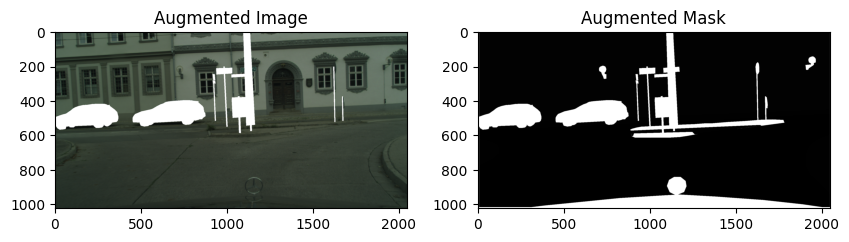

In [98]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

x = '/kaggle/working/cityscapes-segmentation/images/train/erfurt/aug_image_370.png'
y = '/kaggle/working/cityscapes-segmentation/labels/train/erfurt/aug_mask_370.png'

# Verify file paths
if not os.path.exists(x) or not os.path.exists(y):
    raise FileNotFoundError("Image or mask file not found.")

# Read image and mask
image = cv2.imread(x)
mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

if mask is None:
    raise ValueError("Failed to load the mask.")

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title('Augmented Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Augmented Mask')

plt.show()


In [91]:
# import os
# import cv2
# import pandas as pd 
# import torch
# import matplotlib.pyplot as plt
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# # Transform pipeline
# transform = A.Compose([
#     A.Resize(300, 300),  # Resize to (H, W)
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2()  # Convert to tensor
# ])

# # Augmentation pipeline using Albumentations
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
# ])

# def augment_image(image_path, mask_path):
#     """Read and augment the image and mask."""
#     image = cv2.imread(image_path)  # Read the image
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read the mask

#     augmented = augmentation(image=image, mask=mask)  # Apply augmentation
#     aug_image = augmented['image']
#     aug_mask = augmented['mask']

#     return aug_image, aug_mask

# def save_augmented_images(aug_image, aug_mask, output_dir, idx, aug_num):
#     """Save the augmented images and masks."""
#     os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

#     # Generate filenames
    img_filename = f"aug_image_{idx}_{aug_num}.png"
#     mask_filename = f"aug_mask_{idx}_{aug_num}.png"

#     # Save the images in uint8 format
#     aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
#     cv2.imwrite(os.path.join(output_dir, img_filename), aug_image)
#     cv2.imwrite(os.path.join(output_dir, mask_filename), aug_mask)

#     return img_filename, mask_filename

# def generate_augmented_df(df, num_augments=1, output_dir='augmented_images'):
#     """Generate augmented data and store it in a DataFrame."""
#     augmented_data = []

#     for index, row in df.iterrows():
#         image_path = row['image_path']
#         mask_path = row['label_mask_path']

#         for i in range(num_augments):
#             # Augment and save images
#             aug_image, aug_mask = augment_image(image_path, mask_path)
#             img_filename, mask_filename = save_augmented_images(
#                 aug_image, aug_mask, output_dir, index, i
#             )

#             # Apply transformations
#             transformed = transform(image=aug_image, mask=aug_mask)
#             image = transformed['image']
#             mask = transformed['mask']

#             augmented_data.append({
#                 'augmented_image': image,
#                 'augmented_mask': mask,
#                 'image_filename': img_filename,
#                 'mask_filename': mask_filename
#             })

#     # Return the DataFrame
#     return pd.DataFrame(augmented_data)

# def display_sample_images(df, output_dir, num_samples=5):
#     """Display sample augmented images and masks."""
#     samples = df.sample(num_samples)

#     for _, row in samples.iterrows():
#         img_path = os.path.join(output_dir, row['image_filename'])
#         mask_path = os.path.join(output_dir, row['mask_filename'])

#         img = cv2.imread(img_path)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
#         plt.title('Augmented Image')

#         plt.subplot(1, 2, 2)
#         plt.imshow(mask, cmap='gray')
#         plt.title('Augmented Mask')

#         plt.show()

# # Example usage
# df_augmented = pd.DataFrame({
#     'image_path': ['path/to/image1.jpg', 'path/to/image2.jpg'],
#     'label_mask_path': ['path/to/mask1.png', 'path/to/mask2.png']
# })

# augmented_df = generate_augmented_df(df_augmented, num_augments=5)
# display_sample_images(augmented_df, output_dir='augmented_images', num_samples=3)


IndentationError: unexpected indent (4263532851.py, line 38)

In [ ]:
# import os
# import cv2
# import pandas as pd
# import torch
# import albumentations as A
# from albumentations.core.composition import OneOf
# from albumentations.pytorch import ToTensorV2

# transform = A.Compose([
#     A.Resize(300, 300),  # Resize to (H, W)
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize pixel values
# ])
# # Augmentation pipeline
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
# ])

# def augment_image(image_path, mask_path):
#     image = cv2.imread(image_path)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ensure mask stays grayscale
    
#     augmented = augmentation(image=image, mask=mask)
#     aug_image = augmented['image']
# #     .permute(1, 2, 0).cpu().numpy() # Convert tensor to NumPy array
#     aug_mask = augmented['mask']

#     return aug_image, aug_mask


# def generate_augmented_df(df, num_augments=1, output_dir='augmented_data'):
# #     os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exists
#     ha=0
#     augmented_data = []

#     for index, row in df.iterrows():
#         image_path = row['image_path']
#         mask_path = row['label_mask_path']
        
#         for i in range(num_augments):
#             aug_image, aug_mask = augment_image(image_path, mask_path)
#             plt.figure(figsize=(10, 5))
#             plt.subplot(1, 2, 1)
#             plt.imshow(aug_image)
#             plt.title('Augmented Image')

#             plt.subplot(1, 2, 2)
#             plt.imshow(aug_mask, cmap='gray')
#             plt.title('Augmented Mask')
#             plt.show()

#             transformed = transform(image=aug_image, mask=aug_mask)
#             image = transformed['image']
#             mask = transformed['mask']

#             ha=ha+1
#             print(ha)
#             augmented_data.append({
#                 'augmented_image': torch.tensor(image).permute(2, 0, 1),  # HWC -> CHW
#                 'augmented_mask': torch.tensor(mask)  # Mask as tensor
#             })

#     # Create DataFrame from augmented data
#     augmented_df = pd.DataFrame(augmented_data)
#     return augmented_df,ha


# augmented_df ,h= generate_augmented_df(df_augmented, num_augments=1)
# print(augmented_df,h)


In [ ]:
# import os
# import cv2
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch

# def load_image_and_mask(image_path, mask_path):
#     image = cv2.imread(image_path)  # BGR format
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     transformed = transform(image=image, mask=mask)
#     image = transformed['image']
#     mask = transformed['mask']
    
#     image_tensor = torch.tensor(image).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
#     mask_tensor = torch.tensor(mask).unsqueeze(0)  # Add channel dim: (H, W) -> (1, H, W)

#     return image_tensor, mask_tensor

# def create_image_dataframe(df):
#     data = []

#     for index, row in df.iterrows():
#         image_path = row['image_path']
#         mask_path = row['label_mask_path']

#         image_tensor, mask_tensor = load_image_and_mask(image_path, mask_path)
        
#         data.append({
#             'image_tensor': image_tensor,  # Image tensor
#             'mask_tensor': mask_tensor     # Mask tensor
#         })

#     # Create a DataFrame with the loaded data
#     image_df = pd.DataFrame(data)
#     return image_df

# # Example usage with train_df
# loaded_train_df = create_image_dataframe(train_df)

# # Display the first few rows of the DataFrame
# print(loaded_train_df.head())

# # Example: Visualize a loaded image and mask from the DataFrame
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(loaded_train_df.iloc[0]['image_tensor'].permute(1, 2, 0).numpy())  # CHW -> HWC
# plt.title('Loaded Image')

# plt.subplot(1, 2, 2)
# plt.imshow(loaded_train_df.iloc[0]['mask_tensor'].squeeze(0).numpy(), cmap='gray')  # Remove channel dim
# plt.title('Loaded Mask')

# plt.show()


In [ ]:
print(loaded_train_df)

In [ ]:
# import pandas as pd
# import torch

# def load_data_in_batches(train_df, augmented_df, batch_size=32):
#     for i in range(0, len(train_df), batch_size):
#         train_images = train_df['image_tensor'].iloc[i:i + batch_size].tolist()
#         train_masks = train_df['mask_tensor'].iloc[i:i + batch_size].tolist()
        
#         augmented_images = augmented_df['augmented_image'].tolist()
#         augmented_masks = augmented_df['augmented_mask'].tolist()
        
#         combined_images = train_images + augmented_images
#         combined_masks = train_masks + augmented_masks

#         yield combined_images, combined_masks

# # Create a new DataFrame and load in batches
# new_df_list = []

# for images, masks in load_data_in_batches(loaded_train_df, augmented_df, batch_size=32):
#     new_df_list.append(pd.DataFrame({
#         'image_tensor': images,
#         'mask_tensor': masks
#     }))

# # Concatenate all DataFrames
# new_df = pd.concat(new_df_list, ignore_index=True)

# # Display the resulting DataFrame
# print(new_df)


### PreProcessing & The rest

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device) #4744

In [ ]:
#TODO : Write the model you are going to use (Pytorch)

In [ ]:
#TODO : Write the loss function you are going to use

In [ ]:
#TODO : Write the evaluation metrics you are going to use

In [ ]:
#TODO : Write your own Training loop using pytorch

In [ ]:
#TODO : Plot losses and metrics graphs

In [ ]:
#TODO : Test your model and show some samples